**Note!** The generated data comes in the shape of (batch size, time series length, no. features). This means that if we want to visualize one batch of data, we do `data[0].T`. Tranpose is important to put features as rows to show multivariate data correctly!

## MIMIC3

All of these experiments have been done for the MIMIC-III *mortality* dataset (classification task), NOT the *blood pressure* part (regression task).

In [1]:
import numpy as np
import torch as th

SEED = 42  # The default seed set in the tint experiments, and subsequently used by us
FOLD = 1  # For this fold we have all methods

### Load different explanation models

In [2]:
from tint.utils.model_loading import load_explainer

(
    extremal_mask_attr_mimic,
    extremal_mask_explainer_mimic,
    extremal_mask_mask_net_mimic,
) = load_explainer(dataset_name="mimic3", method="extremal_mask", seed=SEED, fold=FOLD)
(
    dyna_mask_attr_mimic,
    dyna_mask_explainer_mimic,
    dyna_mask_mask_net_mimic,
) = load_explainer(dataset_name="mimic3", method="dyna_mask", seed=SEED, fold=FOLD)
aug_occlusion_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3", method="augmented_occlusion", seed=SEED, fold=FOLD
)
deep_lift_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3", method="deep_lift", seed=SEED, fold=FOLD
)
integrated_gradients_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3", method="integrated_gradients", seed=SEED, fold=FOLD
)
retain_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3", method="retain", seed=SEED, fold=FOLD
)

Could not find and load experiments/checkpoints/mimic3_augmented_occlusion_mask_42_1
Could not find and load experiments/checkpoints/mimic3_deep_lift_mask_42_1
Could not find and load experiments/checkpoints/mimic3_integrated_gradients_mask_42_1
Could not find and load experiments/checkpoints/mimic3_retain_mask_42_1


### Load MIMIC-III dataset (only possible with access to MIMIC-III dataset)

This can ONLY be done if you have gained access here

In [3]:
from tint.datasets import Mimic3
from pytorch_lightning import seed_everything

FOLD = 1

# Make sure all seeds are set every time for reproducible results
seed_everything(seed=SEED, workers=True)
mimic3 = Mimic3(n_folds=5, fold=FOLD, seed=SEED)

# Need to preprocess train before accessing test
x_train = mimic3.preprocess(split="train")["x"]
inputs_mimic = mimic3.preprocess(split="test")["x"]
# Access whether the patient died or not
y_test = mimic3.preprocess(split="test")["y"]

Seed set to 42


In [4]:
from tint.datasets.mimic3 import lab_IDs, vital_IDs

other_features = ["Gender", "Age", "Ethnicity", "First ICU stay"]
feature_names = np.array(lab_IDs + vital_IDs + other_features)

### Load and evaluate MIMIC-III classifier (only possible with access to MIMIC-III dataset)

In [5]:
import random

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from tint.utils.model_loading import get_classifier

mimic3_cls = get_classifier(experiment="mimic3", seed=SEED, fold=FOLD)
mimic3_cls.eval()

# Define the same trainer as in the experiments
trainer = Trainer(
    max_epochs=100,
    accelerator="cpu",
    devices=1,
    deterministic=True,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)
# This function will take the test dataloader of mimic3
trainer.test(mimic3_cls, dataloaders=mimic3)
print()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.913223147392273
       test_auroc             0.7833251953125
        test_loss           0.25653332471847534
        test_pre            0.5903614163398743
        test_rec            0.11835748702287674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



In [6]:
outcomes_train = mimic3.preprocess(split="train")["y"]
alive_train, dead_train = outcomes_train.unique(return_counts=True)[1]
total_train = len(outcomes_train)
print(f"Total patients in the training set: {total_train}")
print(
    f"Alive patients: {alive_train} ({alive_train/total_train * 100 :.2f}%), dead: {dead_train} ({dead_train/total_train * 100:.2f}%)"
)

Total patients in the training set: 18390
Alive patients: 16514 (89.80%), dead: 1876 (10.20%)


As we can see, the dataset is very imbalanced. We observe that the classifier has achieved a high accuracy (91.3%), but it is not that good having in mind that 89.80% of the data points in the training dataset have negative labels. We should bear this result in mind when looking at our subsequent analysis.

### Figure out at which indices the classifier predicted a positive class

In [7]:
# Batch size = 32, that's why 144 predictions / epochs
predictions = trainer.predict(mimic3_cls, dataloaders=mimic3.test_dataloader())

# Convert classification network's logits to concrete predictions
intermediate = np.array(predictions[0])
for i in range(1, len(predictions)):
    intermediate = np.append(intermediate, predictions[i], axis=0)

predictions = th.argmax(th.tensor(intermediate), dim=1)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
# Take only the dead patients
dead_indices = th.where(y_test == 1)[0]
# For which patients did the classifier correctly predict deaths?
dead_indices[th.where(y_test[dead_indices] == predictions[dead_indices])[0]]

tensor([   4,   64,  223,  316,  345,  399,  673,  687,  728,  747,  764,  928,
         954, 1030, 1073, 1171, 1235, 1317, 1430, 1527, 1680, 1718, 1778, 1801,
        1966, 1971, 1991, 2110, 2242, 2254, 2257, 2381, 2383, 2408, 2430, 2702,
        2717, 2777, 2838, 3045, 3086, 3095, 3113, 3136, 3173, 3262, 3422, 3449,
        3462, 3575, 3585, 3589, 3604, 3661, 3968, 3972, 3983, 4006, 4025, 4061,
        4155, 4256, 4281, 4420, 4483, 4517, 4581])

### Plot saliencies of ExtremalMask and DynaMask methods for a positive class (Figure 1)

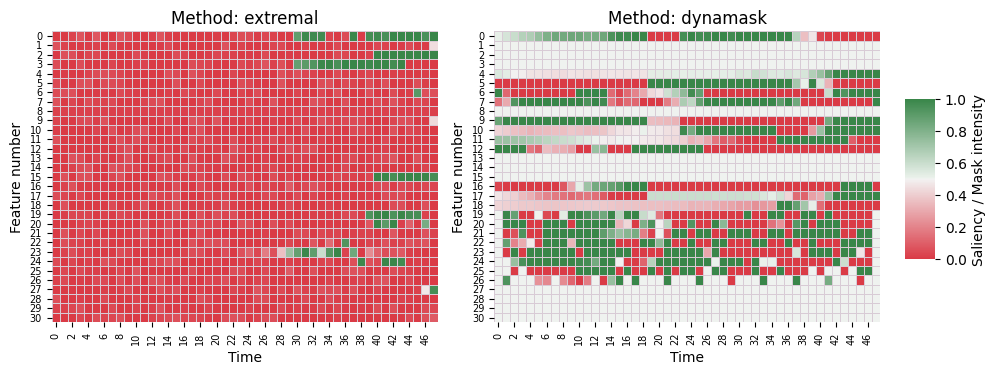

In [9]:
from tint.utils.plotting import plot_heatmap

# This is an example of the indices found above
POS_ID = 64
saliencies = {
    "extremal": extremal_mask_attr_mimic[POS_ID].T,
    "dynamask": dyna_mask_attr_mimic[POS_ID].T,
    title=f"Patient {POS_ID}, prediction = die"
}
plot_heatmap(saliencies, title=None)

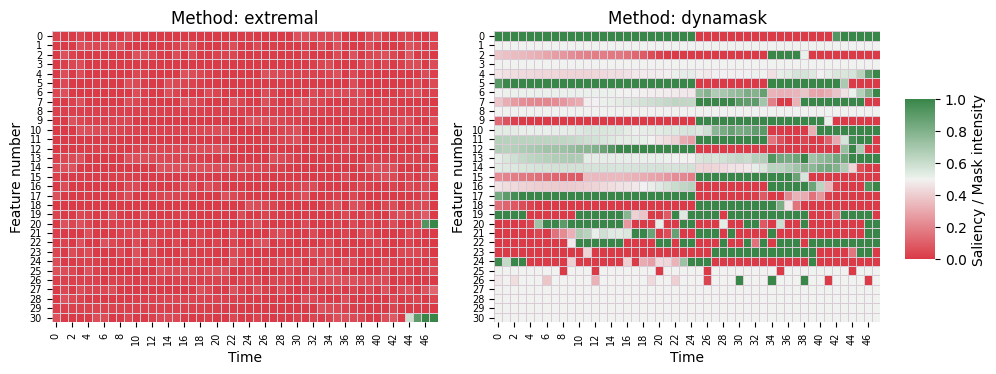

In [10]:
from tint.utils.plotting import plot_heatmap

NEG_ID = 33
saliencies = {
    "extremal": extremal_mask_attr_mimic[NEG_ID].T,
    "dynamask": dyna_mask_attr_mimic[NEG_ID].T,
    title=f"Patient {NEG_ID}, prediction = survive"
}
plot_heatmap(saliencies, title=None)

### Compare many explainer methods on a positive sample (Figure X in the appendix)

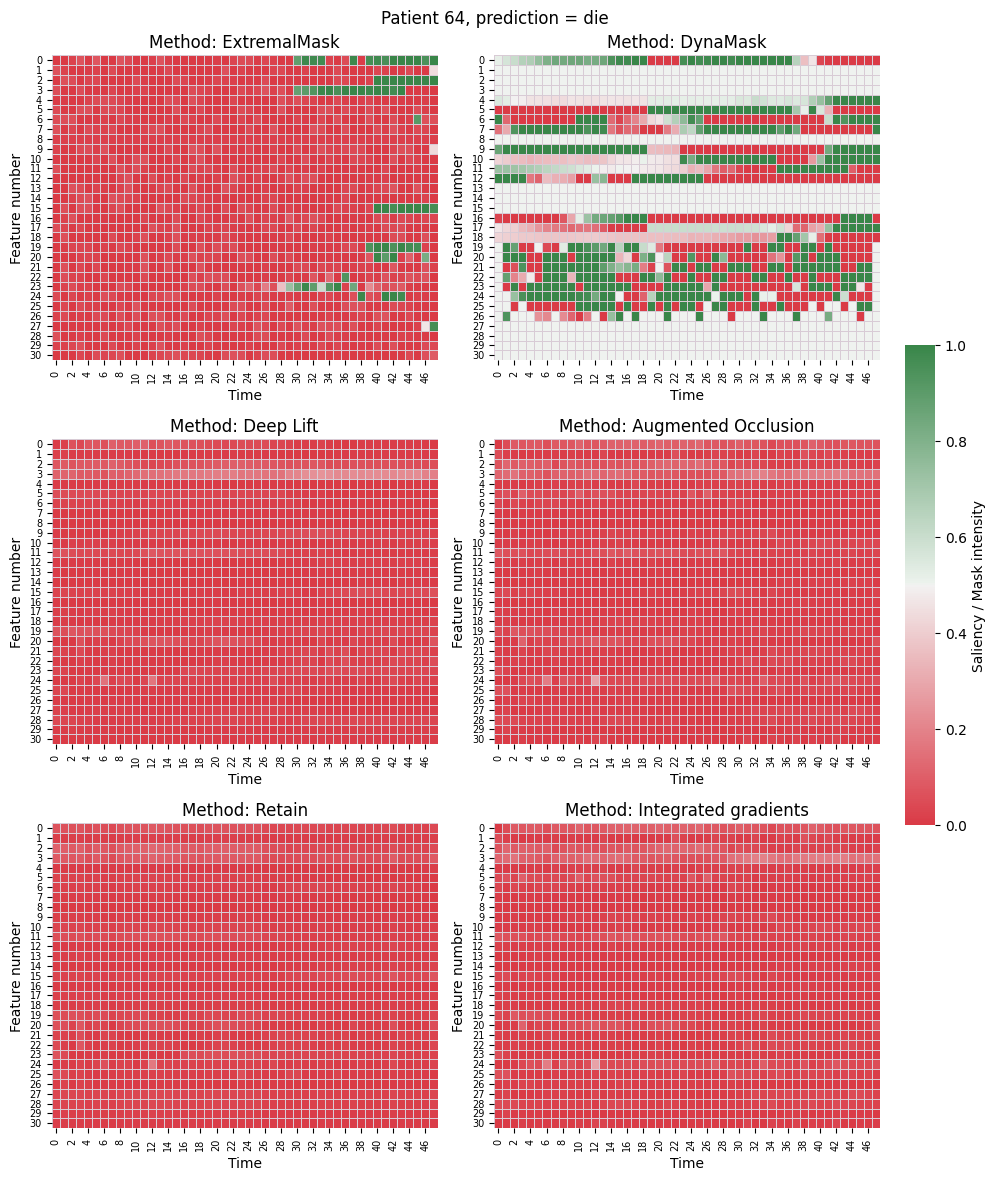

In [11]:
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[POS_ID].T,
    "DynaMask": dyna_mask_attr_mimic[POS_ID].T,
    "Deep Lift": deep_lift_attr_mimic[POS_ID].T,
    "Augmented Occlusion": aug_occlusion_attr_mimic[POS_ID].T,
    "Retain": retain_attr_mimic[POS_ID].T,
    "Integrated gradients": aug_occlusion_attr_mimic[POS_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {POS_ID}, prediction = die")

### Compare many explainer methods on a negative sample (Figure X in the appendix)

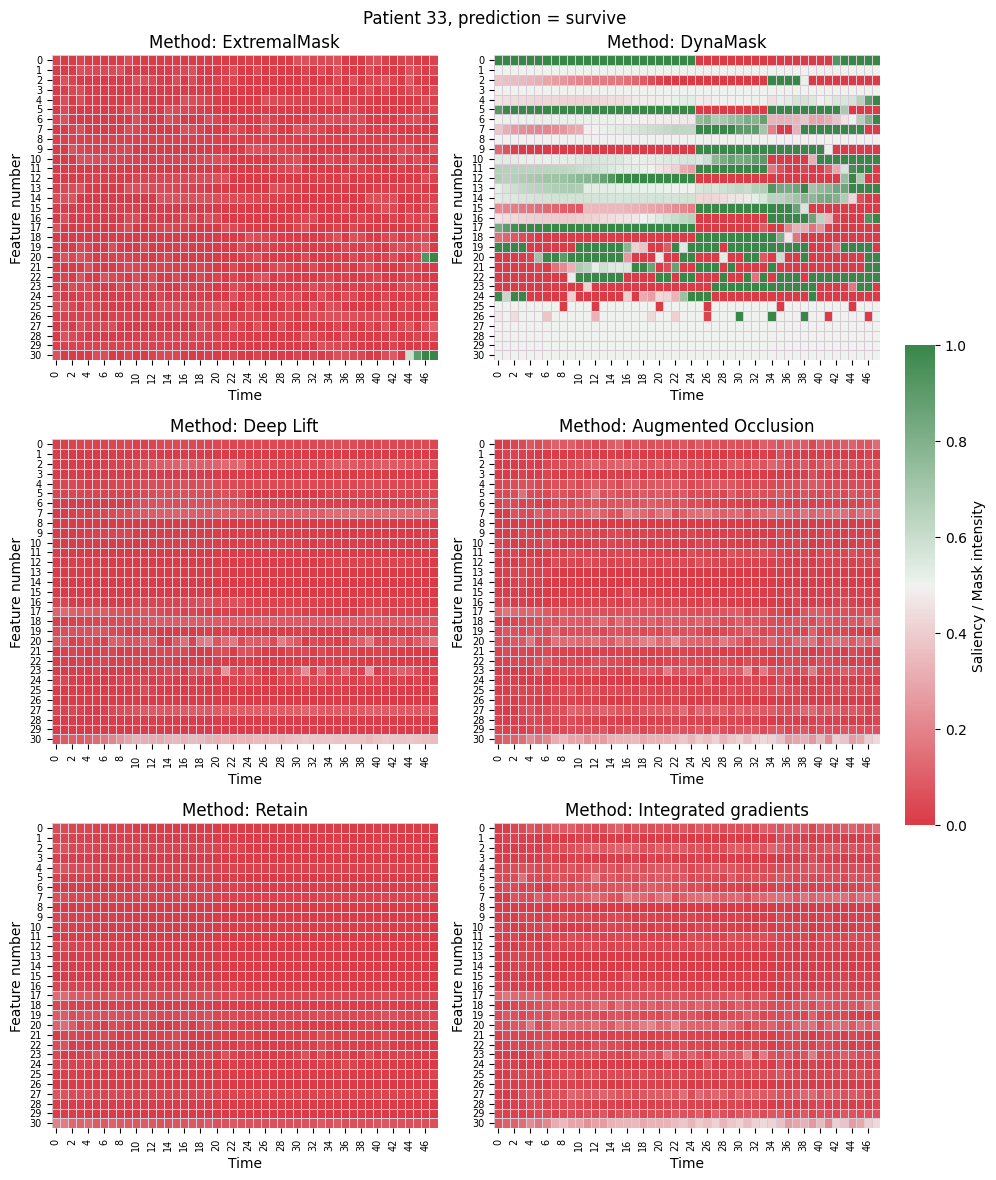

In [12]:
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[NEG_ID].T,
    "DynaMask": dyna_mask_attr_mimic[NEG_ID].T,
    "Deep Lift": deep_lift_attr_mimic[NEG_ID].T,
    "Augmented Occlusion": aug_occlusion_attr_mimic[NEG_ID].T,
    "Retain": retain_attr_mimic[NEG_ID].T,
    "Integrated gradients": aug_occlusion_attr_mimic[NEG_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {NEG_ID}, prediction = survive")

### Detailed visualization of saliency predictions (Figure 2a)

In [13]:
from tint.utils.perturbations import compute_perturbations

# Batch size for extremal was 100, which has idx = 0 if we want to visualize NEG_ID = 33 or POS_ID = 64
(
    extremal_mimic_batch,
    extremal_perturbation_mimic,
    extremal_mask_mimic,
    extremal_x1_mimic,
    extremal_x2_mimic,
) = compute_perturbations(
    data=inputs_mimic,
    mask_net=extremal_mask_mask_net_mimic,
    perturb_net=extremal_mask_mask_net_mimic.net.model,
    batch_idx=0,
)

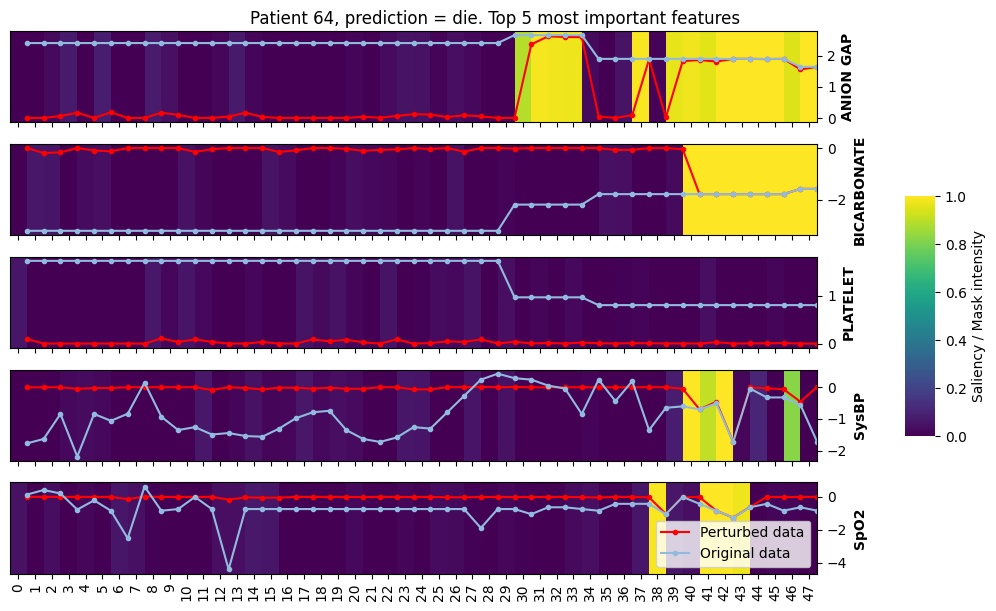

In [14]:
from tint.utils.plotting import plot_saliency

# Take the top 5 important features from the mean attribution plot below
imp_feat_idx = np.array([0, 2, 11, 20, 24])
plot_saliency(
    ts_data=extremal_mimic_batch[POS_ID].T[imp_feat_idx],
    saliency_list=extremal_mask_mimic[POS_ID].T[imp_feat_idx],
    perturbed=extremal_x1_mimic[POS_ID].T[imp_feat_idx],
    suptitle=f"Patient {POS_ID}, prediction = die. Top 5 most important features",
    feature_names=np.array(feature_names)[imp_feat_idx],
)

### Investigate ANION GAP feature at a closer look (Figure X in the Appendix)

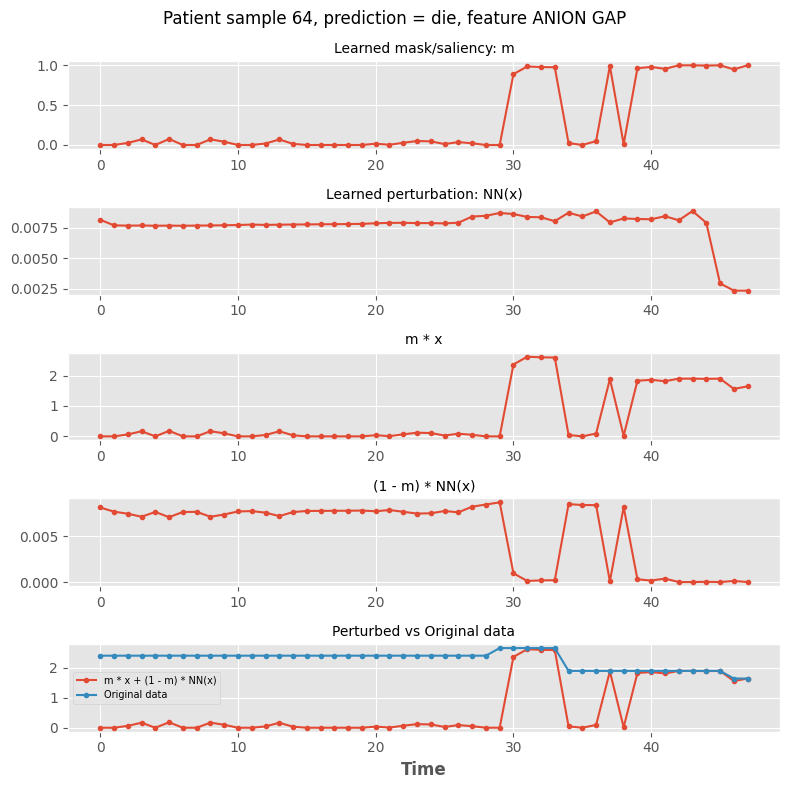

In [15]:
from tint.utils.plotting import plot_components

feat_no = 0  # ANION GAP index
plot_components(
    orig=extremal_mimic_batch[POS_ID].T[feat_no],
    perturbed=extremal_x1_mimic[POS_ID].T[feat_no],
    mask=extremal_mask_mimic[POS_ID].T[feat_no],
    perturbation=extremal_perturbation_mimic[POS_ID].T[feat_no],
    suptitle=f"Patient sample {POS_ID}, prediction = die, feature {feature_names[feat_no]}",
    figsize=(8, 8),
)

### Plotting alternative saliency (Figure 2b)

In [16]:
from tint.utils.perturbations import compute_alternative

extremal_alternative_mimic = compute_alternative(
    extremal_mimic_batch, extremal_mask_mimic, extremal_perturbation_mimic
)

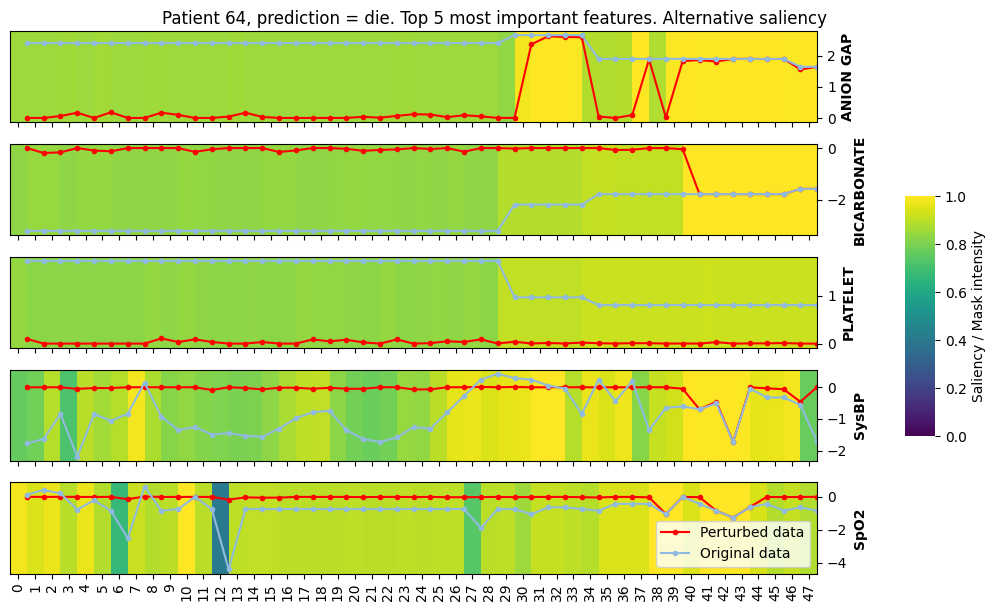

In [17]:
plot_saliency(
    ts_data=extremal_mimic_batch[POS_ID].T[imp_feat_idx],
    saliency_list=extremal_alternative_mimic[POS_ID].T[imp_feat_idx],
    perturbed=extremal_x1_mimic[POS_ID].T[imp_feat_idx],
    suptitle=f"Patient {POS_ID}, prediction = die. Top 5 most important features. Alternative saliency",
    feature_names=np.array(feature_names)[imp_feat_idx],
)

###  Plotting feature importances for identifying deaths in patients (Figure 3 in our paper)

Reproducing Figure 5 from the original paper

In [18]:
# Filter data to postive (dead) patients
dead_indices = th.where(y_test == 1)[0]
dead_attr = extremal_mask_attr_mimic[dead_indices]

In [19]:
dead_attr.shape

torch.Size([414, 48, 31])

414 positive, or dead, patients.

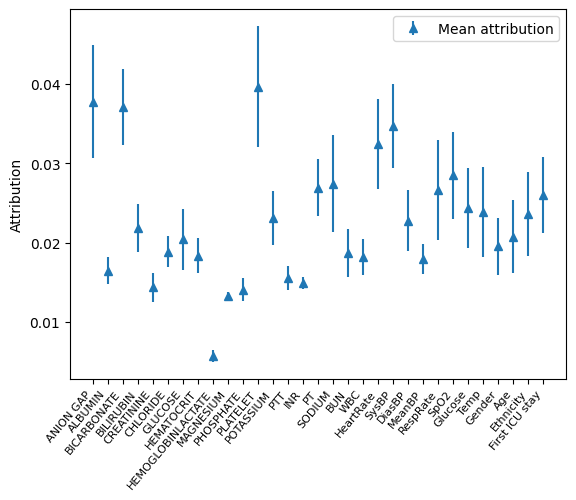

In [33]:
from tint.utils.plotting import plot_mean_attributions

plot_mean_attributions(attr=dead_attr, xtick_labels=feature_names)

In [25]:
mimic_batch, perturbation_mimic, mask_mimic, x1_mimic, x2_mimic = compute_perturbations(
    data=inputs_mimic,
    mask_net=extremal_mask_mask_net_mimic,
    perturb_net=extremal_mask_mask_net_mimic.net.model,
    batch_idx=None,  # Set to None to compute perturbations for the whole dataset
)
alternative_mimic = compute_alternative(
    batch=mimic_batch, mask=mask_mimic, perturbation=perturbation_mimic
)
# Cut alternative to the dead/positive cases
dead_alternative = alternative_mimic[dead_indices]

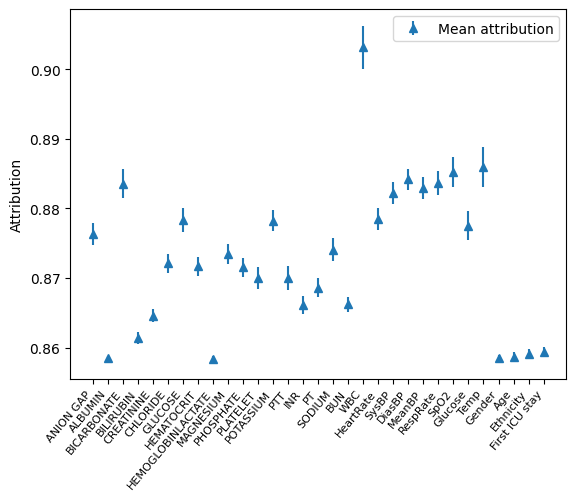

In [31]:
plot_mean_attributions(dead_alternative, xtick_labels=feature_names)

The most important features for identifying deaths using the original saliency are: PLATELET, ANION GAP, BICARBONATE, SysBP, HeartRate. 

The most important features for identifying deaths using the alternative saliency are: WBC, Temp, SpO2, RespRate, DiasBP.

## HMM

In [ ]:
explainer = th.load("experiments/checkpoints/hmm_extremal_mask_42_1.0_1.0_0.ckpt")

In [ ]:
explainer.keys()

In [ ]:
FOLD = 0
dyna_mask_attr_hmm, dyna_mask_explainer_hmm, dyna_mask_mask_net_hmm = load_explainer(
    dataset_name="hmm", method="dyna_mask", seed=SEED, fold=FOLD
)
(
    extremal_mask_attr_mimic_hmm,
    extremal_mask_explainer_hmm,
    extremal_mask_mask_net_hmm,
) = load_explainer(dataset_name="hmm", method="extremal_mask", seed=SEED, fold=FOLD)
fit_attr_mimic, _, _ = load_explainer(
    dataset_name="hmm", method="fit", seed=SEED, fold=FOLD
)
retain_attr_mimic, _, _ = load_explainer(
    dataset_name="hmm", method="retain", seed=SEED, fold=FOLD
)

### Method 1 (shorter)

In [ ]:
# Load HMM data
from tint.datasets import HMM

# Load only the test data because the classifier was trained on train part
# but the mask net and explainer was trained on the test part to explain the
# classifier's decision
# hmm.download(split="train")
# x_train = hmm.preprocess(split="train")["x"]

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)

FOLD = 0

hmm = HMM(n_folds=5, fold=FOLD, seed=SEED)
hmm.download(split="test")
inputs_hmm = hmm.preprocess(split="test")["x"]
y_hmm = hmm.preprocess(split="test")["y"]
true_saliency_hmm = hmm.true_saliency(split="test")
print("batch size, time series length, no. features", inputs_hmm.size())

In [ ]:
import os

from tint.attr.models import ExtremalMaskNet
import torch.nn as nn
from tint.models import RNN, MLP

classifier_hmm = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

classifier_hmm = get_model(
    trainer=None,
    model=classifier_hmm,
    model_name="classifier",
    data_name="hmm",
    seed=SEED,
    fold=FOLD,
    datamodule=None,
)
classifier_hmm.eval()

extremal_mask_net_hmm = ExtremalMaskNet(
    forward_func=classifier_hmm,
    model=nn.Sequential(
        RNN(
            input_size=inputs_hmm.shape[-1],
            rnn="gru",
            hidden_size=inputs_hmm.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * inputs_hmm.shape[-1], inputs_hmm.shape[-1]]),
    ),
    lambda_1=1.0,
    lambda_2=1.0,
    optim="adam",
    lr=0.01,
)
checkpoint_path = (
    f"experiments/checkpoints/hmm_extremal_mask_{SEED}_1.0_1.0_{FOLD}.ckpt"
)

# Make sure the mask is initialized
extremal_mask_net_hmm.net.init(input_size=inputs_hmm.shape, batch_size=100)
extremal_mask_net_hmm.load_state_dict(th.load(checkpoint_path))

# Compute the attributions using the loaded network
extremal_mask_net_hmm.eval()
extremal_attr_hmm = extremal_mask_net_hmm.net.representation()

In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

### Method 2 (longer, using the whole main.py approach)

In [ ]:
from tint.attr import ExtremalMask
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
import random

# try for both devices as well
device = "cpu"
dataset_name = "hmm"
deterministic = True
seed = 42
fold = 1
lambda_1 = 1.0
lambda_2 = 1.0
retrain = False

# If deterministic, seed everything
if deterministic:
    seed_everything(seed=seed, workers=True)

# Get accelerator and device
accelerator = device.split(":")[0]
device_id = 1
if len(device.split(":")) > 1:
    device_id = [int(device.split(":")[1])]

In [ ]:
# If deterministic, seed everything
if deterministic:
    seed_everything(seed=seed, workers=True)

# Get accelerator and device
accelerator = device.split(":")[0]
device_id = 1
if len(device.split(":")) > 1:
    device_id = [int(device.split(":")[1])]

hmm = HMM(n_folds=5, fold=fold, seed=seed)

x_train = hmm.preprocess(split="train")["x"].to(device)
x_test = hmm.preprocess(split="test")["x"].to(device)
y_test = hmm.preprocess(split="test")["y"].to(device)
true_saliency = hmm.true_saliency(split="test").to(device)

In [ ]:
# Create classifier
classifier = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

trainer = Trainer(
    max_epochs=50,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)

classifier = get_model(
    trainer,
    classifier,
    "classifier",
    dataset_name,
    seed,
    fold,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    datamodule=hmm,
    retrain=retrain,
)

# Switch to eval
classifier.eval()

# Set model to device
classifier.to(device)

trainer = Trainer(
    max_epochs=500,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)
mask = ExtremalMaskNet(
    forward_func=classifier,
    model=nn.Sequential(
        RNN(
            input_size=x_test.shape[-1],
            rnn="gru",
            hidden_size=x_test.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * x_test.shape[-1], x_test.shape[-1]]),
    ),
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    optim="adam",
    lr=0.01,
)
explainer = ExtremalMask(dataset_name, classifier, seed, fold)
extremal_attr_hmm = explainer.attribute(
    x_test,
    additional_forward_args=(True,),
    trainer=trainer,
    mask_net=mask,
    batch_size=100,
    retrain=retrain,
)

In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

### STOP HERE

In [ ]:
# Load models trained on HMM data
(
    extremal_attr_hmm2,
    extremal_mask_net_hmm2,
    extremal_explainer_hmm2,
    perturbation_net_hmm2,
    _,
) = load_explainer(explainer_name="42_hmm_extremal2")

# Switch to eval
# classifier_hmm2.eval()
print()

In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm2, true_saliency_hmm):.4}")

### Visualize explanation performance - HMM

In [ ]:
# Visualize true and predicted saliency
SAL_ID = 11
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

In [ ]:
# Visualize true and predicted saliency
SAL_ID = 11
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize learned perturbations - HMM

In [ ]:
# def compute_perturbations(
#     data, mask_net, perturb_net=None, batch_idx: int = 0
# ) -> (th.Tensor, th.Tensor, th.Tensor, th.Tensor, th.Tensor):

# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    data=inputs_hmm,
    mask_net=extremal_mask_net_hmm,
    perturb_net=extremal_mask_net_hmm.net.model,
    batch_idx=0,
)

In [ ]:
# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    inputs_hmm, extremal_mask_net_hmm2, perturb_net=perturbation_net_hmm2, batch_idx=0
)

In [ ]:
extremal_attr_hmm[:100]

In [ ]:
SAL_ID = 14
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    extremal_attr_hmm[:100][SAL_ID].T,
    suptitle="Predicted saliency",
)

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    true_saliency_hmm[SAL_ID].T,
    suptitle="True saliency",
)

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    mask_hmm[SAL_ID].T,
    suptitle="Predicted saliency",
)

In [ ]:
feat_no = 1  # Which specific time series to investigate?
plot_components(
    orig=hmm_batch[SAL_ID].T[feat_no],
    perturbed=x1_hmm[SAL_ID].T[feat_no],
    mask=mask_hmm[SAL_ID].T[feat_no],
    perturbation=perturbation_hmm[SAL_ID].T[feat_no],
    suptitle=f"HMM: data sample {SAL_ID}, feature {feat_no}",
    figsize=(8, 8),
)

In [ ]:
# 1 - (1 - m) * |NN(x) - x|
# Intuition: the higher this value, the more perturbed the data is.
alternative = 1 - (1 - mask_hmm) * th.abs(perturbation_hmm - hmm_batch)
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    alternative[SAL_ID].T,
    suptitle="Alternative saliency",
)

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    true_saliency_hmm[SAL_ID].T,
    suptitle="True saliency",
)

In [ ]:
# plot true saliency vs (1 - m) * |NN(x) - x|
alt_spec = alternative[SAL_ID].T[0]
alternative_normalized = (alt_spec - alt_spec.min()) / (alt_spec.max() - alt_spec.min())
plt.plot(true_saliency_hmm[SAL_ID].T[0], marker=".", label="true")
plt.plot(alternative_normalized, marker=".", label="alternative")
plt.legend()
plt.show()

## Extra: ARMA

Fully whitebox dataset

In [ ]:
from tint.datasets import Arma

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)
arma = Arma(seed=SEED)
# This method generates the dataset
arma.download()
inputs_arma = arma.preprocess()["x"]
true_saliency_arma = arma.true_saliency(dim=1)
res_arma = arma.get_white_box(inputs_arma, true_saliency_arma)

ARMA experiment uses a white box regressor as the main model to explain.

This means, that a number is predicted for each time series in a multivariate time series sample. 

Thus, `res_arma.size()` refers to (batch_size, no. time series in a sample).

In [ ]:
# Load the models trained on ARMA data
(
    extremal_attr_arma,
    extremal_mask_net_arma,
    extremal_explainer_arma,
    _,
    _,
) = load_explainer(experiment="arma", explainer_name="../arma/extremal")

In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_arma, true_saliency_arma):.4}")
print(f"AUR: {aur(extremal_attr_arma, true_saliency_arma):.4}")
print(f"RMSE: {rmse(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Information: {information(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Entropy: {entropy(extremal_attr_arma, true_saliency_arma):.4}")

### Visualize explanation performance - ARMA

In [ ]:
SAL_ID = 100  # Which sample to investigate?
saliencies = {
    "true": true_saliency_arma[SAL_ID].T,
    "extremal": extremal_attr_arma[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize perturbations - ARMA

In [ ]:
arma_batch, perturbation_arma, mask_arma, x1_arma, x2_arma = compute_perturbations(
    inputs_arma, extremal_mask_net_arma, perturb_net=None, batch_idx=0
)

In [ ]:
sample_id = 2  # Which sample to investigate?
FROM = 15  # From which time series
TO = 22  # to which time series to plot?
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    mask_arma[sample_id].T[FROM:TO],
    suptitle="Predicted saliency",
)

In [ ]:
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    true_saliency_arma[sample_id].T[FROM:TO],
    suptitle="True saliency",
)

In [ ]:
sample_id = 2  # Which sample to investigate?
feat_no = 20  # Which specific time series to investigate?
plot_components(
    orig=arma_batch[sample_id].T[feat_no],
    perturbed=x1_arma[sample_id].T[feat_no],
    mask=mask_arma[sample_id].T[feat_no],
    perturbation=perturbation_arma[sample_id].T[feat_no],
    suptitle=f"ARMA: data sample {sample_id}, feature {feat_no}",
    figsize=(8, 8),
)